In [32]:
import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from env.EV_Sce_Env import EV_Sce_Env
import math
import seaborn as sns
import numpy as np

env = EV_Sce_Env('HY_2', seed=0)

In [33]:
point = gpd.read_file('shp/YH.shp')
link = gpd.read_file('shp/YH_link.shp')

agent_num = env.agent_num
od_id = {}
for i in range(link.shape[0]):
    od_id[link.iloc[i]['o-d']] = i

Route Choice

In [34]:
link_list = list(set(link['o-d']))
link_dic = {}
for l in link_list:
    link_dic[l] = 0

for i in range(agent_num):
    route = pd.read_csv('output/HY_2_T1_MAPPO/EV/EV%i_route.csv' % i)
    for j in range(route.shape[0]):
        link_dic[route.iloc[j]['edge']] += 1

link_count = pd.DataFrame(list(link_dic.items()), columns=['o-d', 'count'])
link1 = pd.merge(link, link_count, how='left', on='o-d')
link1['count'] = link1['count'].fillna(0)

link1.to_file('shp/YH_link_test.shp', driver='ESRI Shapefile')

Route Counts

In [35]:
route_con = {}
route_list = {}
for i in range(env.agent_num):
    ev_id = i
    df_r = pd.read_csv('output/HY_2_T1_MAPPO/EV/EV{}_route.csv'.format(ev_id))
    route = list(df_r['edge'])
    r = route[0]
    for j in range(1, len(route)):
        next_p = route[j].split('-')[-1]
        r += "-"+next_p
    if r not in route_con.keys():
        route_con[r] = 1
        route_list[r] = [ev_id]
    else:
        route_con[r] += 1
        route_list[r].append(ev_id)

In [36]:
link2 = link.copy()
for r in route_con.keys():
    link2[r] = 0
for r in route_con.keys():
    point_seq = r.split('-')
    for i in range(1, len(point_seq)):
        link2.loc[od_id[point_seq[i-1]+'-'+point_seq[i]], r] = route_con[r]

link2.to_file('shp/YH_link_test2.shp', driver='ESRI Shapefile')

C:\Users\10199\AppData\Local\Temp\ipykernel_19056\902422355.py:9: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  link2.to_file('shp/YH_link_test2.shp', driver='ESRI Shapefile')


Route Attribute

In [37]:
route_list

{'0-1-2-3-4-9': [0, 1, 3, 4, 7, 9, 10, 14, 16, 17, 19, 21, 28],
 '0-6-9': [2, 5, 27],
 '0-6-7-8-9': [6, 8, 15, 18, 23, 25, 26],
 '0-1-2-3-4-5-9': [11, 12, 22, 24],
 '0-2-3-4-5-9': [13],
 '0-1-2-3-9': [20, 29]}

Charging num at CS

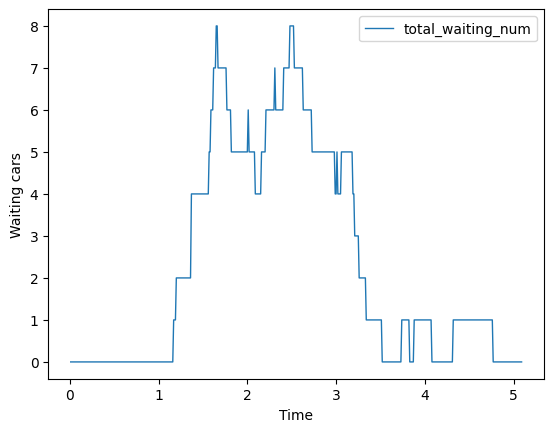

In [ ]:
df_cs = pd.read_csv('output/HY_2_T1_MAPPO/CS.csv')
time = df_cs['time']
total_time = list(df_cs['time'])

columns = []
for i in range(1, env.num_cs-1):
    columns.append('CS{}_waiting_num'.format(i))

df_cs['total_waiting_num'] = df_cs[columns].sum(axis=1)

plt.plot(
    time, df_cs['total_waiting_num'], label='total_waiting_num',
    linewidth=1
    )
plt.xlabel('Time')
plt.ylabel('Waiting cars')
plt.legend()

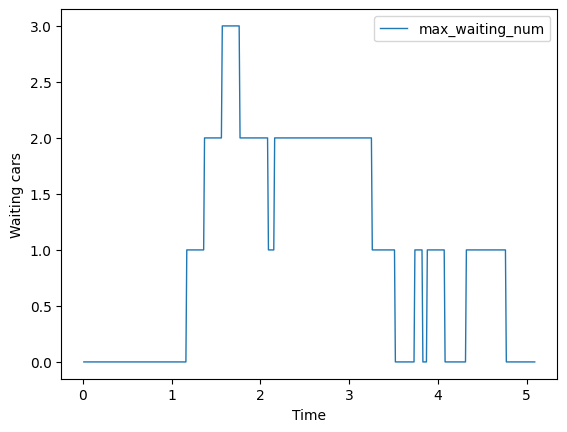

In [49]:
df_cs['max_waiting_num'] = df_cs[columns].max(axis=1)

plt.plot(
    time, df_cs['max_waiting_num'], label='max_waiting_num',
    linewidth=1
    )
plt.xlabel('Time')
plt.ylabel('Waiting cars')
plt.legend()

In [43]:
point1 = point.copy()

t = 1.65
point1['wn_{}'.format(t)] = 0
for i in range(1, point1.shape[0]-1):
    point1.loc[i, 'wn_{}'.format(t)] = df_cs[df_cs['time'] == t]['CS{}_waiting_num'.format(i)].iloc[0]

t = 2.5
point1['wn_{}'.format(t)] = 0
for i in range(1, point1.shape[0]-1):
    point1.loc[i, 'wn_{}'.format(t)] = df_cs[df_cs['time'] == t]['CS{}_waiting_num'.format(i)].iloc[0]

point1.to_file('shp/YH_test.shp', driver='ESRI Shapefile', encoding='utf-8')

Charging num at CS

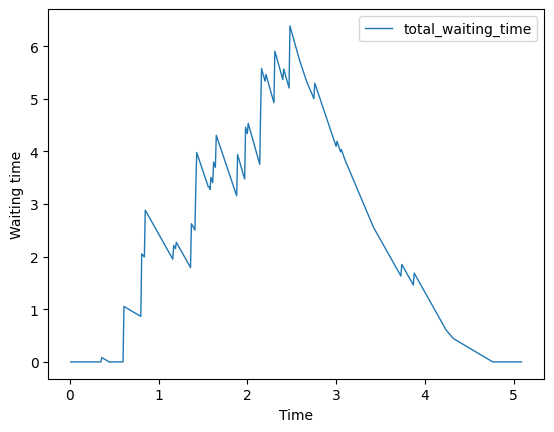

In [50]:
df_cs = pd.read_csv('output/HY_2_T1_MAPPO/CS.csv')
time = df_cs['time']
total_time = list(df_cs['time'])

columns = []
for i in range(1, env.num_cs-1):
    columns.append('CS{}_waiting_time'.format(i))

df_cs['total_waiting_time'] = df_cs[columns].sum(axis=1)

plt.plot(
    time, df_cs['total_waiting_time'], label='total_waiting_time',
    linewidth=1
    )
plt.xlabel('Time')
plt.ylabel('Waiting time')
plt.legend()

In [54]:
df_cs[df_cs['total_waiting_time'] == df_cs['total_waiting_time'].max()]

,time,CS1_waiting_num,CS1_charging_num,CS1_waiting_time,CS2_waiting_num,CS2_charging_num,CS2_waiting_time,CS3_waiting_num,CS3_charging_num,CS3_waiting_time,...,CS8_waiting_num,CS8_charging_num,CS8_waiting_time,CS0_waiting_num,CS0_charging_num,CS0_waiting_time,CS9_waiting_num,CS9_charging_num,CS9_waiting_time,total_waiting_time
247,2.48,0,0,0.0,1,2,0.19125,1,2,0.7,...,2,2,1.7625,0.0,0.0,0.0,0.0,0.0,0.0,6.385


In [55]:
point2 = point.copy()

t = 2.48
point2['wt_{}'.format(t)] = 0
for i in range(1, point2.shape[0]-1):
    point2.loc[i, 'wt_{}'.format(t)] = df_cs[df_cs['time'] == t]['CS{}_waiting_time'.format(i)].iloc[0]

point2.to_file('shp/YH_test2.shp', driver='ESRI Shapefile', encoding='utf-8')

C:\Users\10199\AppData\Local\Temp\ipykernel_19056\2927992275.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.1912499999999986' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  point2.loc[i, 'wt_{}'.format(t)] = df_cs[df_cs['time'] == t]['CS{}_waiting_time'.format(i)].iloc[0]
